# Forecasting solar flares using neural networks for classification
***


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [23]:
# Load raw dataframe
df = pd.read_csv("./Data/data_storms.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     244535 non-null  object 
 1   ABS_B        244535 non-null  float64
 2   F            244535 non-null  float64
 3   BX_GSE       244535 non-null  float64
 4   BY_GSE       244535 non-null  float64
 5   BZ_GSE       244535 non-null  float64
 6   SIGMA-ABS_B  244535 non-null  float64
 7   SIGMA-B      244535 non-null  float64
 8   SIGMA-Bx     244535 non-null  float64
 9   SIGMA-By     244535 non-null  float64
 10  SIGMA-Bz     244535 non-null  float64
 11  T            244535 non-null  float64
 12  N            244535 non-null  float64
 13  V            244535 non-null  float64
 14  Ratio        244535 non-null  float64
 15  Pressure     244535 non-null  float64
 16  R            244535 non-null  int64  
 17  DST          244535 non-null  float64
 18  storm_now    244535 non-

# Changing the dataframe to fit NN
***

In [24]:
# Ensure the 'DATE' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     244535 non-null  datetime64[ns]
 1   ABS_B        244535 non-null  float64       
 2   F            244535 non-null  float64       
 3   BX_GSE       244535 non-null  float64       
 4   BY_GSE       244535 non-null  float64       
 5   BZ_GSE       244535 non-null  float64       
 6   SIGMA-ABS_B  244535 non-null  float64       
 7   SIGMA-B      244535 non-null  float64       
 8   SIGMA-Bx     244535 non-null  float64       
 9   SIGMA-By     244535 non-null  float64       
 10  SIGMA-Bz     244535 non-null  float64       
 11  T            244535 non-null  float64       
 12  N            244535 non-null  float64       
 13  V            244535 non-null  float64       
 14  Ratio        244535 non-null  float64       
 15  Pressure     244535 non-null  floa

In [25]:
# Analyze storm distribution over time

# Number of storm-hours per year
df_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum'])
print(df_storms)

          sum
datetime     
1995      371
1996       31
1997      284
1998      555
1999      424
2000      554
2001      677
2002      904
2003      335
2004      354
2005      533
2006       93
2007       20
2008       12
2009       17
2010       84
2011      201
2012      425
2013      224
2014      163
2015      659
2016      219
2017      213
2018       80
2019       24
2020       21
2021       51
2022      159
2023      386
2024      572


In [26]:
# Number of hours with storms (count should be 8760 [24*365] or 8784 for leap years)
yearly_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum', 'count'])
print("\nHours with storm distribution by year:")
print(yearly_storms)


Hours with storm distribution by year:
          sum  count
datetime            
1995      371   8628
1996       31   8578
1997      284   8121
1998      555   8328
1999      424   6840
2000      554   7034
2001      677   7466
2002      904   7613
2003      335   6439
2004      354   6948
2005      533   8508
2006       93   7723
2007       20   8230
2008       12   8649
2009       17   8550
2010       84   7966
2011      201   8313
2012      425   8651
2013      224   8412
2014      163   6897
2015      659   8670
2016      219   8741
2017      213   8712
2018       80   8751
2019       24   8643
2020       21   8722
2021       51   8549
2022      159   8716
2023      386   8614
2024      572   8523


In [27]:
def create_lagged_features(df, n_hours=3):
    """
    Create features using the last n_hours of data to predict the next hour's storm.
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Features to use (exclude datetime and target)
    feature_cols = [col for col in df.columns if col not in ['datetime', 'storm_now']]
    
    # Create lagged features for each of the past n_hours
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_hours + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next hour's storm (shift storm_now by -1)
    lagged_df['target'] = df['storm_now'].shift(-1)
    lagged_df['datetime'] = df['datetime']
    
    # Drop rows with NaN (first n_hours rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [28]:
# Create the lagged features for the past 3 hours
lagged_data = create_lagged_features(df, n_hours=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 244531 entries, 3 to 244533
Data columns (total 53 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ABS_B_lag1        244531 non-null  float64       
 1   F_lag1            244531 non-null  float64       
 2   BX_GSE_lag1       244531 non-null  float64       
 3   BY_GSE_lag1       244531 non-null  float64       
 4   BZ_GSE_lag1       244531 non-null  float64       
 5   SIGMA-ABS_B_lag1  244531 non-null  float64       
 6   SIGMA-B_lag1      244531 non-null  float64       
 7   SIGMA-Bx_lag1     244531 non-null  float64       
 8   SIGMA-By_lag1     244531 non-null  float64       
 9   SIGMA-Bz_lag1     244531 non-null  float64       
 10  T_lag1            244531 non-null  float64       
 11  N_lag1            244531 non-null  float64       
 12  V_lag1            244531 non-null  float64       
 13  Ratio_lag1        244531 non-null  float64       
 14  Pressure_

In [29]:
# The dataset is too big to run the hyperparameter opitmization in my PC, so I am going to use a sample for this part
lagged_data_short = lagged_data.sample(frac=0.10)
print(lagged_data_short.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24453 entries, 230896 to 36675
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ABS_B_lag1        24453 non-null  float64       
 1   F_lag1            24453 non-null  float64       
 2   BX_GSE_lag1       24453 non-null  float64       
 3   BY_GSE_lag1       24453 non-null  float64       
 4   BZ_GSE_lag1       24453 non-null  float64       
 5   SIGMA-ABS_B_lag1  24453 non-null  float64       
 6   SIGMA-B_lag1      24453 non-null  float64       
 7   SIGMA-Bx_lag1     24453 non-null  float64       
 8   SIGMA-By_lag1     24453 non-null  float64       
 9   SIGMA-Bz_lag1     24453 non-null  float64       
 10  T_lag1            24453 non-null  float64       
 11  N_lag1            24453 non-null  float64       
 12  V_lag1            24453 non-null  float64       
 13  Ratio_lag1        24453 non-null  float64       
 14  Pressure_lag1     2445

In [30]:
# chronological split is important for time series
lagged_data_short = lagged_data_short.sort_values('datetime').reset_index(drop=True)
assert lagged_data_short['datetime'].is_monotonic_increasing

print(lagged_data_short.head())

   ABS_B_lag1  F_lag1  BX_GSE_lag1  BY_GSE_lag1  BZ_GSE_lag1  \
0         3.5     2.9         -0.5          2.9         -0.2   
1        12.3     6.3          4.4          0.2          4.5   
2        13.1    12.7          7.7        -10.1          1.2   
3         9.0     6.5          5.3         -0.1          3.8   
4         5.9     2.8          1.9         -1.6          1.2   

   SIGMA-ABS_B_lag1  SIGMA-B_lag1  SIGMA-Bx_lag1  SIGMA-By_lag1  \
0               0.3           1.9            1.0            0.9   
1               3.0          10.9            6.3            5.9   
2               0.4           2.7            1.1            1.0   
3               1.4           6.0            3.2            3.3   
4               0.4           5.0            2.0            2.3   

   SIGMA-Bz_lag1  ...  SIGMA-Bz_lag3    T_lag3  N_lag3  V_lag3  Ratio_lag3  \
0            1.3  ...            0.9   38322.0    12.5   313.0       0.018   
1            6.5  ...            2.6   76720.0    29.4  

In [31]:
# let's check all columns to drop some on the next step
print(lagged_data_short.columns)

Index(['ABS_B_lag1', 'F_lag1', 'BX_GSE_lag1', 'BY_GSE_lag1', 'BZ_GSE_lag1',
       'SIGMA-ABS_B_lag1', 'SIGMA-B_lag1', 'SIGMA-Bx_lag1', 'SIGMA-By_lag1',
       'SIGMA-Bz_lag1', 'T_lag1', 'N_lag1', 'V_lag1', 'Ratio_lag1',
       'Pressure_lag1', 'R_lag1', 'DST_lag1', 'ABS_B_lag2', 'F_lag2',
       'BX_GSE_lag2', 'BY_GSE_lag2', 'BZ_GSE_lag2', 'SIGMA-ABS_B_lag2',
       'SIGMA-B_lag2', 'SIGMA-Bx_lag2', 'SIGMA-By_lag2', 'SIGMA-Bz_lag2',
       'T_lag2', 'N_lag2', 'V_lag2', 'Ratio_lag2', 'Pressure_lag2', 'R_lag2',
       'DST_lag2', 'ABS_B_lag3', 'F_lag3', 'BX_GSE_lag3', 'BY_GSE_lag3',
       'BZ_GSE_lag3', 'SIGMA-ABS_B_lag3', 'SIGMA-B_lag3', 'SIGMA-Bx_lag3',
       'SIGMA-By_lag3', 'SIGMA-Bz_lag3', 'T_lag3', 'N_lag3', 'V_lag3',
       'Ratio_lag3', 'Pressure_lag3', 'R_lag3', 'DST_lag3', 'target',
       'datetime'],
      dtype='object')


In [32]:
# Separate features and target
# I started using the DST feature, and it is be very useful, but it is not always available in real-time forecasts
#X = lagged_data_short.drop(['datetime', 'target', 'DST_lag1', 'DST_lag2', 'DST_lag3'], axis=1)
X = lagged_data_short.drop(['datetime', 'target'], axis=1)
y = lagged_data_short['target']

print(X.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24453 entries, 0 to 24452
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ABS_B_lag1        24453 non-null  float64
 1   F_lag1            24453 non-null  float64
 2   BX_GSE_lag1       24453 non-null  float64
 3   BY_GSE_lag1       24453 non-null  float64
 4   BZ_GSE_lag1       24453 non-null  float64
 5   SIGMA-ABS_B_lag1  24453 non-null  float64
 6   SIGMA-B_lag1      24453 non-null  float64
 7   SIGMA-Bx_lag1     24453 non-null  float64
 8   SIGMA-By_lag1     24453 non-null  float64
 9   SIGMA-Bz_lag1     24453 non-null  float64
 10  T_lag1            24453 non-null  float64
 11  N_lag1            24453 non-null  float64
 12  V_lag1            24453 non-null  float64
 13  Ratio_lag1        24453 non-null  float64
 14  Pressure_lag1     24453 non-null  float64
 15  R_lag1            24453 non-null  float64
 16  DST_lag1          24453 non-null  float6

In [33]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 19562
Test samples: 4891

Class distribution in training set:
target
0.0    18833
1.0      729
Name: count, dtype: int64
Percentage of positive cases in train: 3.73%

Class distribution in test set:
target
0.0    4782
1.0     109
Name: count, dtype: int64
Percentage of positive cases in test: 2.23%


In [34]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Apply SMOTE to balance the training data
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

#print(f"\nAfter SMOTE:")
#print(f"Training samples: {len(X_train_balanced)}")
#print(pd.Series(y_train_balanced).value_counts())

In [36]:
# the model
n_features = X_train_scaled.shape[1]

model = Sequential([
    Input(shape=(n_features,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [37]:
# the metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

In [38]:
# train
es = EarlyStopping(patience=10, restore_best_weights=True)

class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9694 - Precision: 0.2579 - Recall: 0.9326 - loss: 0.2343 - val_AUC: 0.9824 - val_Precision: 0.2608 - val_Recall: 0.9717 - val_loss: 0.1907
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9841 - Precision: 0.3328 - Recall: 0.9615 - loss: 0.1746 - val_AUC: 0.9910 - val_Precision: 0.2442 - val_Recall: 0.9906 - val_loss: 0.1930
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9885 - Precision: 0.3807 - Recall: 0.9759 - loss: 0.1296 - val_AUC: 0.9908 - val_Precision: 0.3000 - val_Recall: 0.9623 - val_loss: 0.1473
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9894 - Precision: 0.3844 - Recall: 0.9663 - loss: 0.1300 - val_AUC: 0.9925 - val_Precision: 0.2837 - val_Recall: 0.9717 - val_loss: 0.1503
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9922 - Precision: 0.4111 - Recall: 0.9791 - loss: 0.1082 - val_AUC: 0.9925 - val_Precision: 0.3505 - val_Recall: 0.9623 - val_loss: 0.

In [39]:
# evaluate
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.04547179490327835, 'compile_metrics': 0.5642458200454712}


In [ ]:
# save and load
model.save('./Data/flares_keras.keras')
# later
model = load_model('./Data/flares_keras.keras')

In [41]:
# Predict
y_pred_proba = model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [42]:
# --- Metrics ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[4704   78]
 [   8  101]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      4782
         1.0       0.56      0.93      0.70       109

    accuracy                           0.98      4891
   macro avg       0.78      0.96      0.85      4891
weighted avg       0.99      0.98      0.98      4891


Evaluation Metrics:
       Metric  Score
           F2 0.8211
           F1 0.7014
       Recall 0.9266
Avg Precision 0.8900
      ROC AUC 0.9963



Visualization saved as 'solar_flare_NN_results.png'


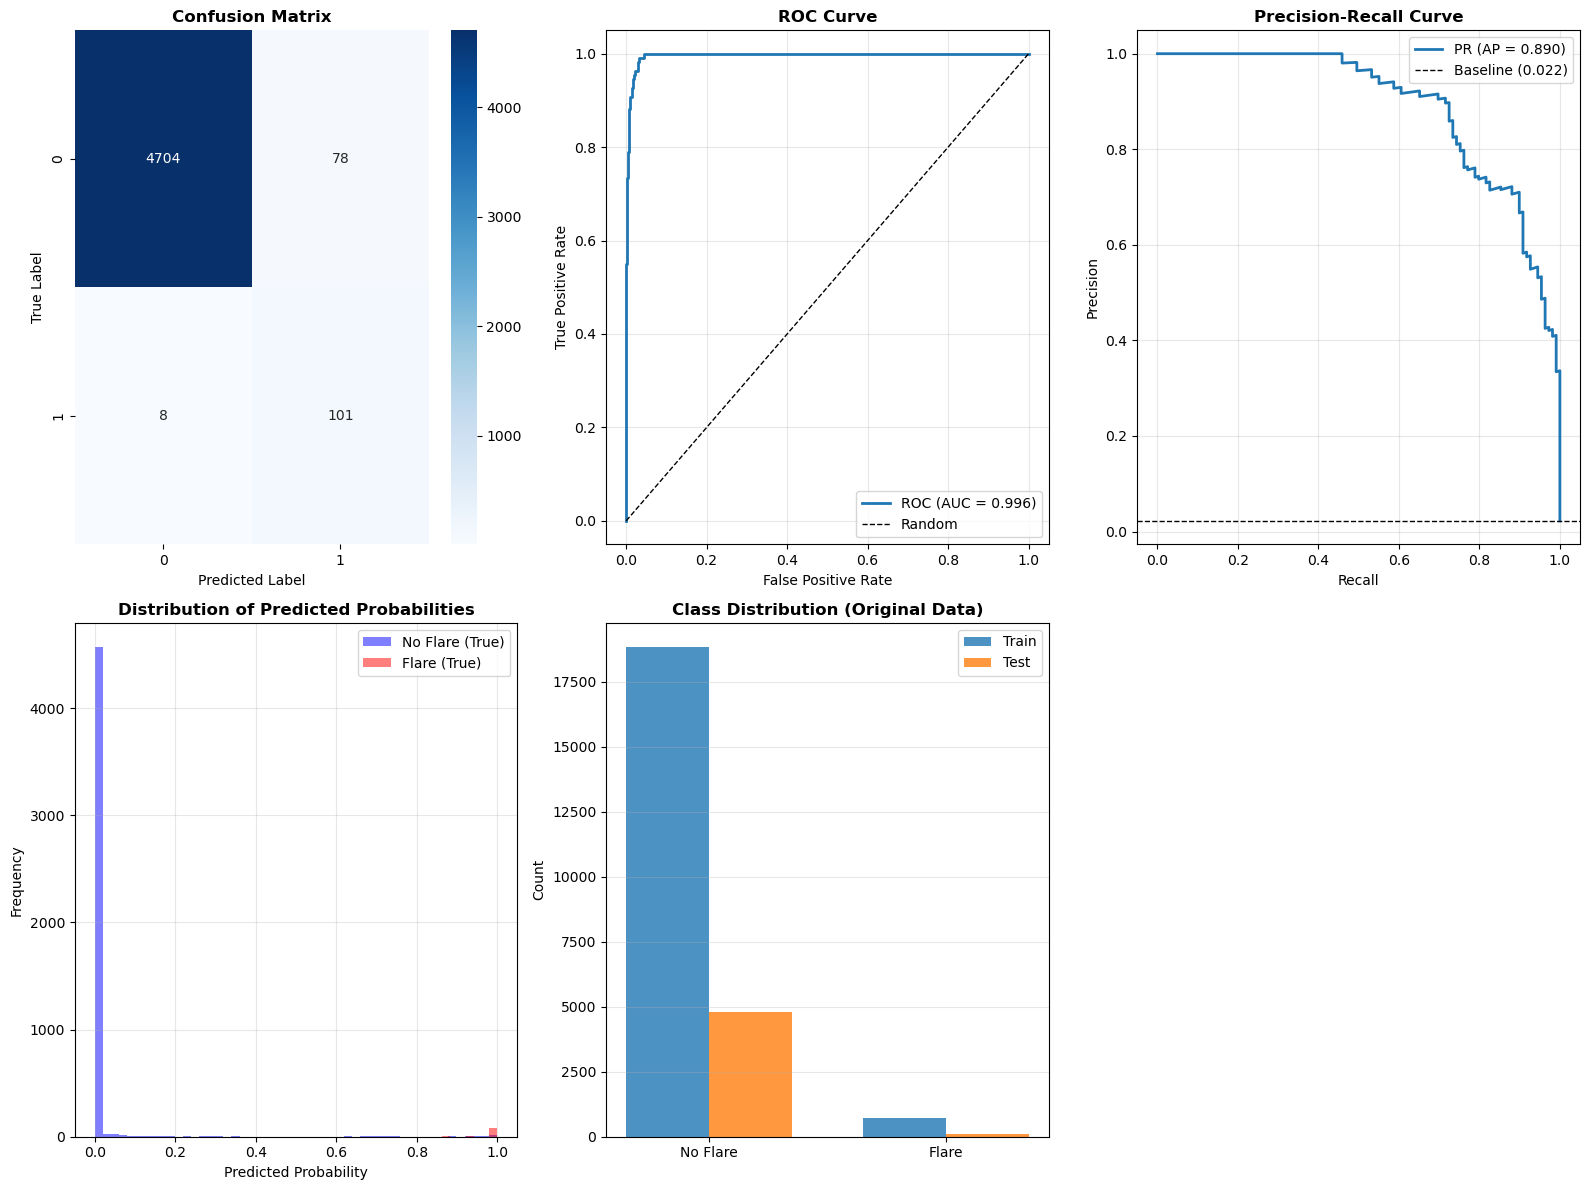

In [43]:
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. ROC Curve
if len(np.unique(y_test)) > 1:
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax3.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax3.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 4)
ax5.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax5.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Class Distribution
ax6 = plt.subplot(2, 3, 5)
train_dist = [sum(y_train == 0), sum(y_train == 1)]
test_dist = [sum(y_test == 0), sum(y_test == 1)]
x = np.arange(2)
width = 0.35
ax6.bar(x - width/2, train_dist, width, label='Train', alpha=0.8)
ax6.bar(x + width/2, test_dist, width, label='Test', alpha=0.8)
ax6.set_ylabel('Count')
ax6.set_title('Class Distribution (Original Data)', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['No Flare', 'Flare'])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./Figures/solar_flare_NN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_NN_results.png'")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Training curves saved as 'solar_flare_keras_training_curves.png'


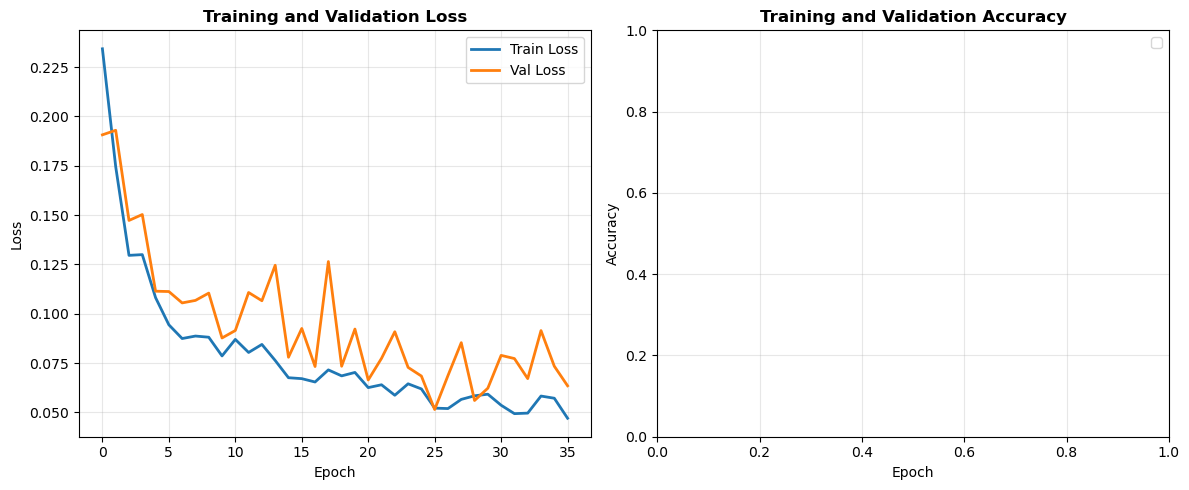

In [44]:
# --- 7. Training History ---
if 'history' in locals():
    hist = history.history
    fig2 = plt.figure(figsize=(12, 5))

    # 7a. Loss
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax1.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 7b. Accuracy
    ax2 = plt.subplot(1, 2, 2)
    if 'accuracy' in hist:
        ax2.plot(hist['accuracy'], label='Train Accuracy', linewidth=2)
    if 'val_accuracy' in hist:
        ax2.plot(hist['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('./Figures/solar_flare_keras_training_curves.png', dpi=300, bbox_inches='tight')
    print("\nTraining curves saved as 'solar_flare_keras_training_curves.png'")
    plt.show()
else:
    print("No training history available.")


In [45]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold = 0.3
  TP: 104, FP: 98, TN: 4684, FN: 5
  Precision: 0.515, Recall: 0.954

Threshold = 0.4
  TP: 103, FP: 83, TN: 4699, FN: 6
  Precision: 0.554, Recall: 0.945

Threshold = 0.5
  TP: 101, FP: 78, TN: 4704, FN: 8
  Precision: 0.564, Recall: 0.927

Threshold = 0.6
  TP: 100, FP: 71, TN: 4711, FN: 9
  Precision: 0.585, Recall: 0.917

Threshold = 0.7
  TP: 99, FP: 58, TN: 4724, FN: 10
  Precision: 0.631, Recall: 0.908
